**Notebook for loading our pretrained StylEx and reproducing our results**

Please click the following link 

https://drive.google.com/file/d/1kxDHAFRmiadTOtaCXsKUf-ISir3bF23M/view?usp=sharing

and use the top right button "add shortcut to drive" to add the .zip file to "MyDrive".

We will now proceed to mount your Google Drive and unzip the .zip into colab memory (your drive won't be affected).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip 'gdrive/MyDrive/results.zip'

unzip:  cannot find or open gdrive/MyDrive/results.zip, gdrive/MyDrive/results.zip.zip or gdrive/MyDrive/results.zip.ZIP.


In [3]:
# install dependencies
!pip install tfrecord

     |████████████████████████████████| 49 kB 2.6 MB/s 
  Created wheel for tfrecord: filename=tfrecord-1.14.1-py3-none-any.whl size=15652 sha256=177c3f657448464a58b69305dc10d4d1c4fd2f23f687dd09933773fb25e5f526
  Stored in directory: /root/.cache/pip/wheels/07/63/59/2a382bd2e3051f622bf8742e79f2641d78b29523680f57bf74
Successfully built tfrecord


In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import os
import IPython.display
import pickle
import requests
import collections

from tfrecord.torch.dataset import TFRecordDataset

from mobilenet_pytorch import MobileNetV1
from stylegan2_pytorch.training import networks

from utils import *

CLASSIFIER_PATH = './models/classifier.pth'
DISCRIMINATOR_PATH = './models/discriminator/discriminator.pth'
ENCODER_PATH = './models/encoder/encoder.pth'
GENERATOR_PATH = './models/generator/generator.pth'


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


## Load pretrained models:
We load the pretrained pytorch models after transferring their tensorflow models 

In [ ]:
torch.manual_seed(0)

classifier = MobileNetV1()
classifier.load_state_dict(torch.load(CLASSIFIER_PATH))
classifier.eval()

generator = load_torch_generator(pth_file=GENERATOR_PATH)
generator.eval()

encoder = load_torch_encoder(pth_file=ENCODER_PATH)
encoder.eval()

discriminator = load_torch_discriminator(pth_file=DISCRIMINATOR_PATH)
discriminator.eval()
print("")

Loading generator's necessary kwargs...
Creating generator model...
Loading generator's state dict...
Done
Loading encoder's necessary kwargs...
Creating encoder model...
Loading encoder's state dict...
Done
Loading discrimintor's necessary kwargs...
Creating discrimintor model...
Loading discrimintor's state dict...
Done



In [ ]:
#Global variables

num_layers = 14
label_size = 2
resolution = 256

## Latents extraction: 

Here we present how to run the encoder on one image, to calculate one dlatent (we pre-calculate for 250).
We don't provide the dataset_provider, so we will load the dlatents from a precomputed np.array.

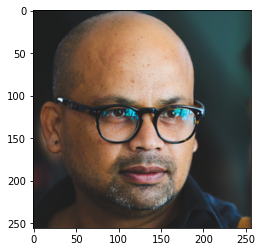

In [ ]:
image = plt.imread('./data/img_to_encode.png').transpose(2,0,1)
logits = classifier(torch.from_numpy(image).unsqueeze(0))
dlat = create_dlat_from_img_and_logits(encoder, logits, image)

expanded_dlatent_tmp = torch.tile(dlat,[1, num_layers, 1])

# Feed dlatent into the generator
gen_output = generator.synthesis(expanded_dlatent_tmp)
img_out = torch.maximum(torch.minimum(gen_output, torch.Tensor([1])), torch.Tensor([-1]))

img_out = img_out[0].detach().numpy()
img_out = np.transpose(image, (1, 2, 0))
plt.imshow(img_out)

Here we show how to load the precomputed dlatents they provide

In [ ]:
#@title Load the precomputed dlatents (already concatenated to the labels)
latents_file = open("./data/saved_dlantents.pkl",'rb')
dlatents = pickle.load(latents_file)

## Create image given a dlatent

We choose the index of one of the 250 preloaded dlatents from which we generate an image

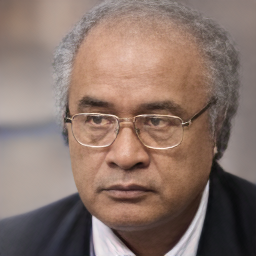

In [ ]:
img_index = 37

# Choose dlatent and make it into [1,num_layers,514]
dlat = torch.Tensor(dlatents[img_index][1])
expanded_dlatent_tmp = torch.tile(dlat,[1, num_layers, 1])

# Feed dlatent into the generator
gen_output = generator.synthesis(expanded_dlatent_tmp)
img_out = torch.maximum(torch.minimum(gen_output, torch.Tensor([1])), torch.Tensor([-1]))
show_images(img_out)

### Generate Style space per index (min max)

In [ ]:
#@title Load effect data from the tfrecord {form-width: '20%'}
data_path = './data/examples_1.tfrecord'
num_classes = 2
print(f'Loaded dataset: {data_path}')
index_path = None
description = {"dlatent": "float", "result": "float", "base_prob": "float"}
dataset = TFRecordDataset(data_path, index_path, description)
loader = torch.utils.data.DataLoader(dataset, batch_size=1)

style_change_effect = []
dlatents = []
base_probs = []
for raw_record in iter(loader):
  dlatents.append(
      np.array(raw_record['dlatent']))
  seffect = np.array(
      raw_record['result']).reshape(
          (-1, 2, num_classes))
  style_change_effect.append(seffect.transpose([1, 0, 2]))
  base_probs.append(
      np.array(raw_record['base_prob']))

base_probs = np.array(base_probs)
style_change_effect = np.array(style_change_effect)
dlatents = torch.from_numpy(np.array(dlatents))
expanded_dlatent_tmp = torch.tile(dlatents, [1, num_layers, 1])
W_values, style_change_effect, base_probs = dlatents.squeeze(), style_change_effect.squeeze(), base_probs.squeeze()

style_change_effect = filter_unstable_images(style_change_effect, effect_threshold=2)
all_style_vectors = torch.cat(generator.synthesis.style_vector_calculator(expanded_dlatent_tmp)[1], dim=1).numpy()
style_min = np.min(all_style_vectors, axis=0)
style_max = np.max(all_style_vectors, axis=0)

all_style_vectors_distances = np.zeros((all_style_vectors.shape[0], all_style_vectors.shape[1], 2))
all_style_vectors_distances[:,:, 0] = all_style_vectors - np.tile(style_min, (all_style_vectors.shape[0], 1))
all_style_vectors_distances[:,:, 1] = np.tile(style_max, (all_style_vectors.shape[0], 1)) - all_style_vectors

Loaded dataset: ./data/examples_1.tfrecord


## Run the extraction step of AttFind

In [ ]:
#@title Split by class
all_labels = np.argmax(base_probs, axis=1)
style_effect_classes = {}
W_classes = {}
style_vectors_distances_classes = {}
all_style_vectors_classes = {}
for img_ind in range(label_size):
  img_inx = np.array([i for i in range(all_labels.shape[0]) 
  if all_labels[i] == img_ind])
  curr_style_effect = np.zeros((len(img_inx), style_change_effect.shape[1], 
                                style_change_effect.shape[2], style_change_effect.shape[3]))
  curr_w = np.zeros((len(img_inx), W_values.shape[1]))
  curr_style_vector_distances = np.zeros((len(img_inx), style_change_effect.shape[2], 2))
  for k, i in enumerate(img_inx):
    curr_style_effect[k, :, :] = style_change_effect[i, :, :, :]
    curr_w[k, :] = W_values[i, :]
    curr_style_vector_distances[k, :, :] = all_style_vectors_distances[i, :, :]
  style_effect_classes[img_ind] = curr_style_effect
  W_classes[img_ind] = curr_w
  style_vectors_distances_classes[img_ind] = curr_style_vector_distances
  all_style_vectors_classes[img_ind] = all_style_vectors[img_inx]
  print(f'Class {img_ind}, {len(img_inx)} images.')

Class 0, 90 images.
Class 1, 160 images.


In [ ]:
#@title Significant S values - combined {form-width: '20%'}
label_size_clasifier = 2 
num_indices =  8
effect_threshold = 0.2
s_indices_and_signs_dict = {}

for class_index in [0, 1]:
  split_ind = 1 - class_index
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]

  # Find s indicies
  s_indices_and_signs = find_significant_styles(
    style_change_effect=all_s,
    num_indices=num_indices,
    class_index=class_index,
    generator=generator,
    classifier=classifier,
    all_dlatents=all_w,
    style_min=style_min,
    style_max=style_max,
    max_image_effect=effect_threshold*5,
    label_size=label_size_clasifier,
    sindex_offset=0)

  s_indices_and_signs_dict[class_index] = s_indices_and_signs

# Combine the style indicies for the two classes.
sindex_class_0 = [sindex for _, sindex in s_indices_and_signs_dict[0]]

all_sindex_joined_class_0 = [(1 - direction, sindex) for direction, sindex in 
                             s_indices_and_signs_dict[1] if sindex not in sindex_class_0]
all_sindex_joined_class_0 += s_indices_and_signs_dict[0]

scores = []
for direction, sindex in all_sindex_joined_class_0:
  other_direction = 1 if direction == 0 else 0
  curr_score = np.mean(style_change_effect[:, direction, sindex, 0]) + np.mean(style_change_effect[:, other_direction, sindex, 1])
  scores.append(curr_score)

s_indices_and_signs = [all_sindex_joined_class_0[i] for i in np.argsort(scores)[::-1]]

print('Directions and style indices for moving from class 1 to class 0 = ', s_indices_and_signs[:num_indices])
print('Use the other direction to move for class 0 to 1.')

Directions and style indices for moving from class 1 to class 0 =  [(1, 5300), (0, 5147), (1, 3301), (1, 3199), (1, 3921), (1, 1208), (0, 5246), (0, 4172)]
Use the other direction to move for class 0 to 1.


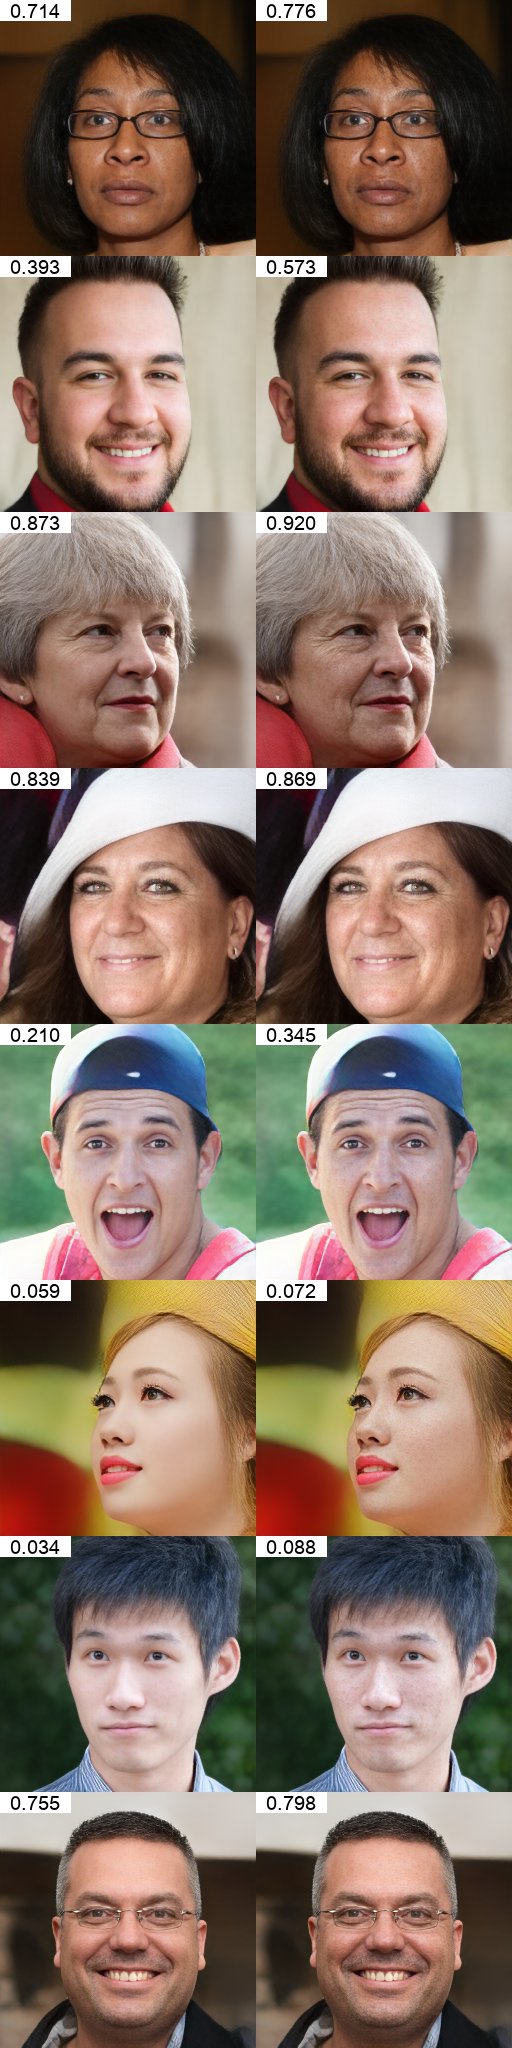

In [ ]:
max_images = 8 
sindex = 5300 
class_index = 0 
shift_sign = "1" 
wsign_index = int(shift_sign)

shift_size =  1 
effect_threshold = 0 
split_by_class = False 
select_images_by_s_distance = True 
draw_probabilities_on_image = True 

if split_by_class:
  split_ind = 1 if class_index == 0 else 0
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]
  all_s_distances = style_vectors_distances_classes[split_ind]
else:
  all_s = style_change_effect
  all_w = W_values
  all_s_distances = all_style_vectors_distances

font_file = './arialuni.ttf'
if not os.path.exists(font_file):
  r = requests.get('https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/ipwn/arialuni.ttf')
  open(font_file, 'wb').write(r.content)

if not select_images_by_s_distance:
  yy = visualize_style(generator, 
                       classifier,
                       all_w,
                       all_s,
                       style_min,
                       style_max,
                       sindex,
                       wsign_index,
                       max_images=max_images,
                       shift_size=shift_size,
                       font_file=font_file,
                       label_size=label_size,
                       class_index=class_index,
                       effect_threshold=effect_threshold,
                       draw_results_on_image=draw_probabilities_on_image)
    
else:
  yy = visualize_style_by_distance_in_s(
    generator,
    classifier,
    all_w,
    all_s_distances,
    style_min,
    style_max,
    sindex,
    wsign_index,
    max_images=max_images,
    shift_size=shift_size,
    font_file=font_file,
    label_size=label_size,
    class_index=class_index,
    effect_threshold=effect_threshold,
    draw_results_on_image=draw_probabilities_on_image)

if yy.size > 0:
  show_image(yy)
else:
  print('no images found')

Original images are on the first row, the probabilities displayed are for the other class - left column for being old, right column for being young)
Attribute 1: Skin Pigminatation


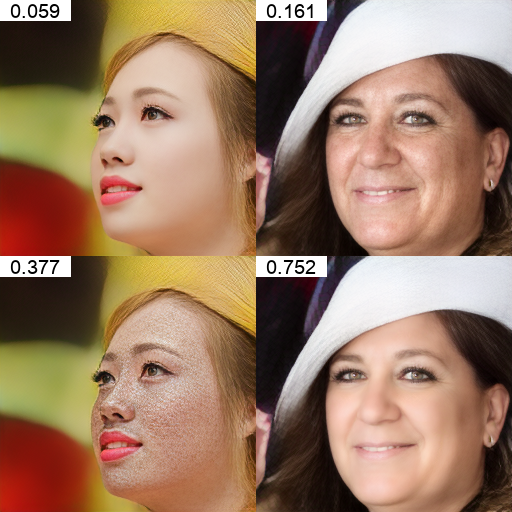

Attribute 2: Eyebrow Thickness


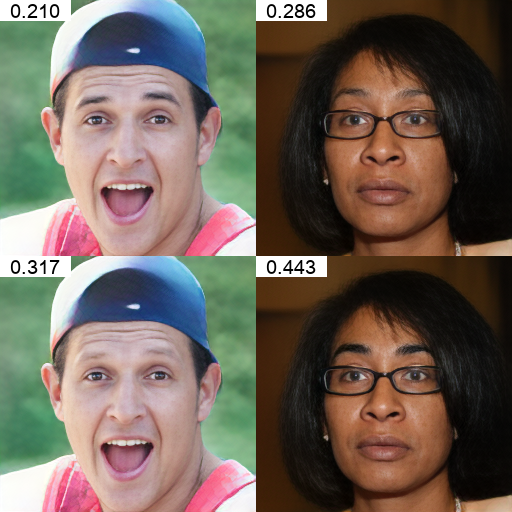

Attribute 3: Add/Remove Glasses


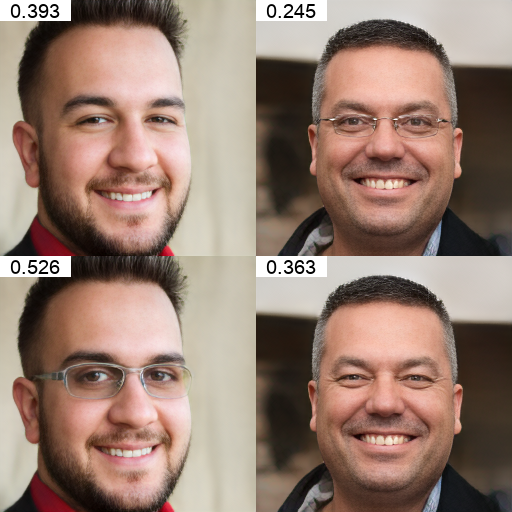

Attribute 4: Dark/White Hair


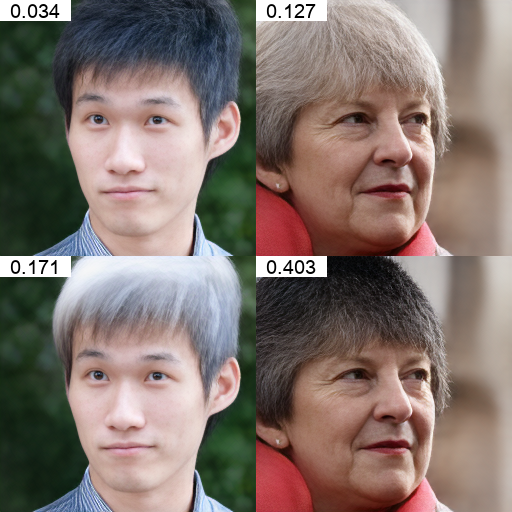

In [ ]:
#Show the 4 top attributes

index_to_naming = {1: "Skin Pigminatation", 2: "Eyebrow Thickness", 3: "Add/Remove Glasses", 4: "Dark/White Hair"}
images_list = [[5, 3], [3, 0], [0, 6], [5, 1]]
shift_sizes = shift_sizes = [(2, 1.5),(1, 1),(1, 1),(1.5, 2)]
effect_threshold = 0

print('Original images are on the first row, the probabilities displayed are for the other class - left column for being old, right column for being young)')

for i, (direction, sindex) in enumerate(s_indices_and_signs[:4]):
  images_s = np.zeros((resolution * 2, resolution * 2, 3)).astype(np.uint8)
  for d in [direction, 1 - direction]:
    class_index = 0 if d == direction else 1
    split_ind = 1 if d == direction else 0
    all_s = style_effect_classes[split_ind]
    all_s_distances = style_vectors_distances_classes[split_ind]
    
    # Generate images
    yy = visualize_style_by_distance_in_s(
      generator,
      classifier,
      all_w,
      all_s_distances,
      style_min,
      style_max,
      sindex,
      d,
      max_images=max_images,
      shift_size=shift_sizes[i][class_index],
      font_file=font_file,
      label_size=label_size,
      class_index=class_index,
      effect_threshold=effect_threshold,
      draw_results_on_image=draw_probabilities_on_image)
    
    for n in range(2):
      images_s[n * resolution: (n + 1) * resolution, class_index * resolution: (class_index + 1) * resolution, :] = yy[(images_list[i][class_index]) * resolution: (images_list[i][class_index] + 1) * resolution, n * resolution: (n + 1) * resolution, :]
  
  print(f'Attribute {i + 1}: {index_to_naming[i+1]}')
  show_image(images_s)

## Image-specific explanations

In this section, we implement the **Independent** selection strategy, to find the top 5 attributes for explaining a perceived-age classifier for a **specific image**


In [ ]:
#Choose latent index to find image's top 5 attributes
latent_index = 131

one_latent = torch.unsqueeze(W_values[latent_index], 0)
one_base_prob = torch.unsqueeze(torch.from_numpy(base_probs[latent_index]), 0)
one_style_change_effect = torch.unsqueeze(torch.from_numpy(style_change_effect[latent_index]), 0)

expanded_dlatent_tmp = torch.tile(one_latent, [1, num_layers, 1])

all_style_vectors = torch.cat(generator.synthesis.style_vector_calculator(expanded_dlatent_tmp)[1], axis=1).numpy()
style_min = np.min(all_style_vectors, axis=0)
style_max = np.max(all_style_vectors, axis=0)

all_style_vectors_distances = np.zeros((all_style_vectors.shape[0], all_style_vectors.shape[1], 2))
all_style_vectors_distances[:,:, 0] = all_style_vectors - np.tile(style_min, (all_style_vectors.shape[0], 1))
all_style_vectors_distances[:,:, 1] = np.tile(style_max, (all_style_vectors.shape[0], 1)) - all_style_vectors

In [ ]:
# Find s indicies
class_index = 0# @param {type: "integer"} 
label_size_clasifier = 2 #@param
num_indices = 5 #@param
effect_threshold = 0.5 #@param

s_indices_and_signs = find_significant_styles(
    style_change_effect=one_style_change_effect.numpy(),
    num_indices=num_indices,
    class_index=class_index,
    generator=generator,
    classifier=classifier,
    all_dlatents=one_latent,
    style_min=style_min,
    style_max=style_max,
    max_image_effect=effect_threshold*5,
    label_size=label_size_clasifier,
    sindex_offset=0)

print(f'Directions and style indices for moving from class 1 (yound) to class {class_index} (old) = ', s_indices_and_signs[:num_indices])

Directions and style indices for moving from class 1 (yound) to class 0 (old) =  [(1, 3301), (0, 3341), (0, 2367), (1, 1208), (1, 3199)]


Attribute 1: Add Glasses


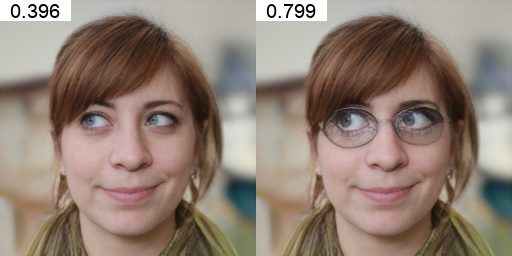

Attribute 2: White Hair


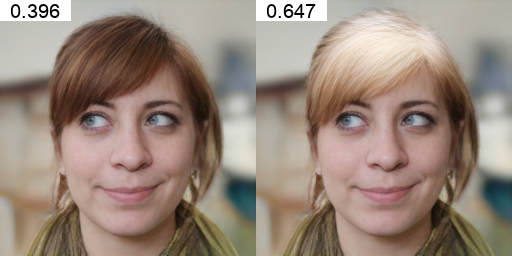

Attribute 3: Neck Coverage


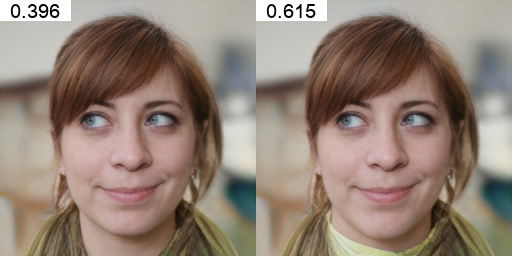

Attribute 4: Receding Hairline


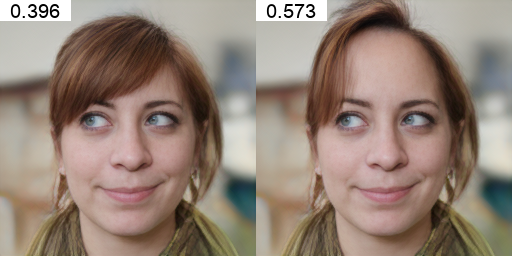

Attribute 5: Glowy White Hair


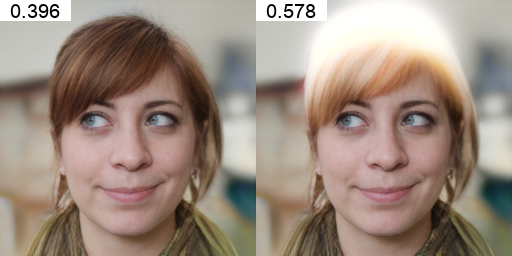

In [ ]:
shift_sign = "0" #@param [0, 1]
wsign_index = int(shift_sign)

shift_size = 2#@param
effect_threshold = 0#@param

shift_sizes = [1, -1.5, -1, 1.5, 2.5]
index_to_naming = {1: "Add Glasses", 2: "White Hair", 3: "Neck Coverage", 4: "Receding Hairline", 5: "Glowy White Hair"}

 
for i, (direction, sindex) in enumerate(s_indices_and_signs[:5]): 
  yy = visualize_style_by_distance_in_s(
      generator,
      classifier,
      one_latent,
      all_style_vectors_distances,
      style_min,
      style_max,
      sindex,
      direction,
      max_images=max_images,
      shift_size=shift_sizes[i],
      font_file=font_file,
      label_size=label_size,
      class_index=class_index,
      effect_threshold=effect_threshold,
      draw_results_on_image=draw_probabilities_on_image,
      images_idx=[0])

  print(f'Attribute {i + 1}: {index_to_naming[i + 1]}')

  if yy.size > 0:
    show_image(yy)

## Quantitative Evaluation
A User Study for Coherence and Distinctness

### Classification study: 

We ask 30 different users the following:

For each of the questions below:

1) Look at the animations on the top. Both are examples of the same transformation.

2) Then look at the two candidates on the bottom, A and B.

3) Choose which one does a similar transformation to those on the left.

Google Form: https://docs.google.com/forms/d/e/1FAIpQLSd6gU662t3YoGQI_ks49Qd1AlRU_DrshvjXzuCSQ7Rzy2Alng/viewform

We calculate the mean and std for both Age and Gender classifiers

In [ ]:
import csv
import inflect
from collections import Counter
import nltk
from nltk.stem import PorterStemmer

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
with open('./studies/classification_study_responses.csv') as fd:
    reader=csv.reader(fd)
    results=[float(i) for idx, row in enumerate(reader) for i in row[1:] if idx == 32] # accuracies are in row 32

age_classifier_results = results[1:7]
gender_classifier_results = results[7:]

In [ ]:
age_mean = np.mean(age_classifier_results)
age_std = np.std(age_classifier_results)
gender_mean = np.mean(gender_classifier_results)
gender_std = np.std(gender_classifier_results)

print('age_mean', age_mean)
print('age_std', age_std)
print('gender_mean', gender_mean)
print('gender_std', gender_std)

age_mean 0.9777777778333334
age_std 0.02484519979968806
gender_mean 0.9444444446666668
gender_std 0.031426968209870294


### Verbal Description Study: 

We ask 30 different users the following:

For each of the questions below:

1) Look at the animation.

2) Describe in 1-4 words the single most prominent attribute that changes for all images.

Google Form: https://docs.google.com/forms/d/e/1FAIpQLSeW8f7eaCzof2MfGsITEpsnZ2srI4r3GDTrBrYX3BDim4T38A/viewform

We calculate the **most common** word used to describe the attribute change observed for Cats/Dogs and Face classifiers seperately.

In [ ]:
f = open('./studies/verbal_study_responses.csv', 'rt', encoding="utf8")
reader = csv.reader(f)
data = [] 
for r in reader: 
    data.append(r)
f.close()

Cats/Dogs classifier

In [ ]:
p = inflect.engine()
porter = PorterStemmer()
for j in range(1, 4):
  att = []
  for i in range(1, 31):
    for k in data[i][j].split():
      k = porter.stem(k)
      if not p.singular_noun(k):
        att.append(k.lower())
      else:
        att.append(p.singular_noun(k).lower())
  tags = nltk.pos_tag(att)
  non_prep_words = [word for word,pos in tags if not (pos == 'CC' or pos == 'VB' or pos == 'IN' or pos == 'DT' or pos == 'RP' or pos == 'PRP$')]
  c = Counter(non_prep_words)
  print(c)
  print("")

Counter({'eye': 22, 'pupil': 5, 'shape': 3, 'colour': 3, 'size': 3, 'light': 3, 'bigger': 2, 'fur': 1, 'color': 1, 'becom': 1, 'tone': 1, 'chang': 1, 'cat': 1, 'eyes,': 1, 'round': 1})

Counter({'mouth': 22, 'open': 9, 'tongu': 5, 'close': 2, 'expres': 1, 'come': 1, 'mouth,': 1, 'chin': 1, 'clariti': 1, 'chang': 1, "cats'": 1, '-': 1, 'outside/insid': 1})

Counter({'ear': 27, 'right': 2, 'becom': 2, 'length': 2, 'size': 1, 'point': 1, 'more': 1, 'bigger': 1, 'angl': 1, 'imag': 1, 'stretch': 1, 'lift': 1, '-': 1, 'bigger/smal': 1, 'pull': 1, 'left': 1, 'shape': 1, 'pointi': 1})



Face classifiers

In [ ]:
p = inflect.engine()
porter = PorterStemmer()
for j in range(4, 11):
  att = []
  for i in range(1, 31):
    for k in data[i][j].split():
      k = porter.stem(k)
      if k in ["mustach", "mustache", "moustach", "moustag"]:
        k = "mustache"
      if k in ["color", "colour"]:
        k = "color"
      if not p.singular_noun(k):
        att.append(k.lower())
      else:
        att.append(p.singular_noun(k).lower())
  tags = nltk.pos_tag(att)
  non_prep_words = [word for word,pos in tags if not (pos == 'CC' or pos == 'VB' or pos == 'IN' or pos == 'DT' or pos == 'RP' or pos == 'PRP$')]
  c = Counter(non_prep_words)
  print(c)
  print("")

Counter({'eyebrow': 27, 'thick': 3, 'thicker': 2, 'brow': 2, 'width': 2, 'color': 1, 'expres': 1, 'are': 1, 'darken': 1, 'becom': 1, 'thinner': 1, '-': 1, 'thicker/thinn': 1, 'bolder': 1, 'eybrow': 1})

Counter({'tooth': 9, 'lip': 3, 'disappear': 2, 'upper': 2, 'show': 2, 'expres': 1, 'smile': 1, 'mouth': 1, 'gglas': 1, 'appear': 1, 'excist': 1, 'remov': 1, '-showing/not': 1, 'lose': 1, 'cover': 1})

Counter({'glas': 27, 'size': 4, 'bigger': 3, 'shape': 2, 'eyeglas': 2, 'becom': 2, 'smaller': 2, 'eye': 1, 'sunglas': 1, 'larger': 1, 'height': 1})

Counter({'mouth': 21, 'open': 12, 'lip': 3, 'bottom': 3, 'tooth': 2, 'close': 2, 'smile': 2, 'down': 1, 'up': 1, 'lower': 1, 'jaw': 1, 'show': 1, 'chin': 1, "(i'm": 1, 'rapper': 1, 'now,': 1, 'yo)': 1})

Counter({'bright': 11, 'skin': 9, 'light': 8, 'color': 4, 'tone': 4, 'imag': 3, 'temperatur': 1, 'pictur': 1, 'darker': 1, 'becom': 1, 'brighter': 1, 'shade': 1, 'chang': 1, 'brigth': 1, 'shadow': 1})

Counter({'mustache': 28, 'facial': 2, 'ha